In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 2 — Basics of Data and Preprocessing
## Lesson 11: Encoding Categorical Features (One-Hot, Ordinal, Hashing, Target Encoding)

### What you will learn
By the end of this lesson, you will be able to:

1. Identify *which* categorical features require encoding and *why* most ML estimators cannot consume raw strings.
2. Implement and compare **one-hot**, **ordinal**, **hashing**, and **target** encoding.
3. Reason about the **statistical and computational tradeoffs**: dimensionality, sparsity, collisions, bias/variance, and leakage risk.
4. Build **production-grade preprocessing pipelines** with `ColumnTransformer` and `Pipeline`, including safe handling of unseen categories.
5. Apply **leakage-safe target encoding** using out-of-fold statistics.

Throughout, we will use multiple datasets from the repository, loaded by relative paths.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, Ridge, SGDClassifier
from sklearn.feature_extraction import FeatureHasher

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


---

## 1. Why categorical encoding is not a cosmetic step

A categorical feature takes values in a **finite set**:
$$
x \in \mathcal{C}=\{c_1,\dots,c_K\}.
$$

Most learning algorithms operate on vectors in $\mathbb{R}^d$ and rely on algebraic operations (inner products, gradients, distances). Raw categories (strings) have **no canonical arithmetic**:
- There is no meaningful definition of $c_i + c_j$ or $2\cdot c_i$.
- Even if you map categories to integers, that mapping creates **artificial geometry** unless the categories are truly ordered.

Encoding is therefore a *representation choice*:
$$
\phi:\mathcal{C}\rightarrow \mathbb{R}^d,\quad \text{and we learn on } \phi(x).
$$

A good encoding should:
- preserve *relevant structure* (e.g., order when it exists),
- avoid injecting *false structure* (e.g., arbitrary integer distances),
- be robust to *unseen categories*,
- control *dimensionality and memory*,
- and (for target encoding) avoid **leakage**.

We will analyze four standard families:
1. One-hot encoding
2. Ordinal encoding
3. Hashing (feature hashing / hashing trick)
4. Target encoding (mean encoding) with leakage-safe variants


## 2. Categorical taxonomy: nominal vs ordinal vs high-cardinality

Categorical variables appear in several forms:

### Nominal (unordered)
Examples: `Sex ∈ {M,F}`, `Color ∈ {Red, Blue, ...}`.
There is **no order**. Encodings must not imply that one category is “larger”.

### Ordinal (ordered)
Examples: education level, ratings (`low < medium < high`), or domain-defined scales.
Here, order is meaningful, and an encoding may exploit that monotonic structure.

### High-cardinality nominal
Examples: product IDs, user IDs, municipalities, free-form categories.
If $K$ (number of unique categories) is large, one-hot may be infeasible because it creates a very high-dimensional sparse matrix.

A convenient summary is:

| Type | Typical $K$ | Encoding candidates | Main risk |
|---|---:|---|---|
| Nominal | small–medium | one-hot | dimensionality if many categories |
| Ordinal | small–medium | ordinal (with explicit ordering) | false ordering if you guess the order |
| High-card nominal | large | hashing, target encoding | collisions (hashing), leakage (target) |

Next, we implement each method with real datasets.


---

## 3. One-hot encoding: the default for nominal categories

### Definition
For a category set $\mathcal{C}=\{c_1,\dots,c_K\}$, one-hot encoding maps
$$
\phi(c_k) = e_k \in \mathbb{R}^K
$$
where $e_k$ is the $k$-th standard basis vector (1 at index $k$, 0 otherwise).

If a sample has multiple categorical fields, one-hot is applied per field and the results are concatenated.

### Dummy-variable trap and identifiability
In linear models with an intercept, one-hot columns for a single feature are linearly dependent:
$$
\sum_{k=1}^{K} e_k = \mathbf{1}.
$$
A common practice is to drop one category (reference coding) or rely on regularization.
In scikit-learn, `OneHotEncoder(drop="first")` drops one category per feature.

### When it works well
- Nominal categories with low–moderate $K$
- Linear / generalized linear models that benefit from sparse, high-dimensional representations
- Many models accept sparse matrices efficiently (e.g., logistic regression with `saga` solver)

We start with the `drug200.csv` dataset (categorical predictors like `Sex`, `BP`, `Cholesterol`).


In [3]:
path_drug = "../../../Datasets/Classification/drug200.csv"
drug = pd.read_csv(path_drug)
drug.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
drug.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


### Build a baseline one-hot pipeline

We will:
1. split train/test,
2. one-hot encode categorical columns,
3. keep numeric columns as-is,
4. fit a multinomial logistic regression.

`handle_unknown="ignore"` is essential for robustness when a new category appears at inference time.


In [5]:
target = "Drug"
X = drug.drop(columns=[target])
y = drug[target]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols


(['Sex', 'BP', 'Cholesterol'], ['Age', 'Na_to_K'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

clf_ohe = Pipeline(steps=[
    ("preprocess", preprocess_ohe),
    ("model", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

clf_ohe.fit(X_train, y_train)

pred = clf_ohe.predict(X_test)
acc = accuracy_score(y_test, pred)
acc


0.98

In [7]:
# Inspect expanded feature space
ohe = clf_ohe.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

num_feature_names = np.array(num_cols, dtype=object)
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

len(all_feature_names), all_feature_names[:12]


(9,
 array(['Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
        'Cholesterol_HIGH', 'Cholesterol_NORMAL', 'Age', 'Na_to_K'],
       dtype=object))

### Interpretability: coefficients per category (linear models)

Logistic regression learns coefficients such that:
$$
\log\frac{P(Y=k\mid x)}{P(Y=\text{ref}\mid x)} = \beta_k^\top \phi(x).
$$

We can inspect which categories push the prediction toward a specific drug.


In [8]:
model = clf_ohe.named_steps["model"]
coef = pd.DataFrame(model.coef_, columns=all_feature_names, index=model.classes_)
coef.iloc[:, :15].round(3)


,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age,Na_to_K
DrugY,-0.228,0.228,0.087,0.044,-0.132,-0.089,0.088,0.003,2.069
drugA,-0.230,0.224,1.611,-0.880,-0.737,0.092,-0.097,-0.086,-0.556
drugB,0.340,-0.334,1.461,-1.008,-0.447,-0.330,0.336,0.124,-0.379
drugC,0.021,-0.024,-0.991,1.707,-0.720,1.133,-1.136,-0.024,-0.653
drugX,0.096,-0.093,-2.169,0.137,2.035,-0.805,0.809,-0.018,-0.480


### Practical notes for one-hot

1. **High cardinality**: if a column has thousands of categories, one-hot can explode memory.
2. **Rare categories**: extremely rare categories may act like noise. A common trick is to group rare categories into `"Other"`.
3. **Trees**: some tree methods can accept integer codes, but one-hot can still be beneficial depending on the library and configuration.


### One-hot in matrix form (and why rank matters)

Suppose you have one nominal feature with $K$ categories and $n$ samples. Let $Z\in\{0,1\}^{n\times K}$ be the one-hot design matrix, where each row has exactly one 1. Then:

- Row sums are 1: $Z\mathbf{1}=\mathbf{1}$.
- If your model includes an intercept (a constant column), then that intercept is **exactly** a linear combination of one-hot columns, creating collinearity.

A simple rank argument:

- Without an intercept, $\text{rank}(Z)=K$ (assuming each category appears at least once).
- With an intercept column appended, the combined matrix is rank $K$ but has $K+1$ columns, so it is not full column rank.
- If you drop one category (reference coding), you get $K-1$ one-hot columns; with an intercept, the matrix can become full rank.

In practice, many solvers can handle collinearity via regularization, but being explicit about the encoding makes debugging and interpretation easier.


In [9]:
# Demonstrate rank / collinearity on a single categorical feature from drug200

Z_full = pd.get_dummies(drug["BP"], prefix="BP")  # K columns
Z_full_mat = Z_full.to_numpy()

# Add intercept
X_full = np.column_stack([np.ones(len(Z_full_mat)), Z_full_mat])

rank_Z = np.linalg.matrix_rank(Z_full_mat)
rank_X_full = np.linalg.matrix_rank(X_full)

Z_drop = pd.get_dummies(drug["BP"], prefix="BP", drop_first=True)  # K-1 columns
X_drop = np.column_stack([np.ones(len(Z_drop)), Z_drop.to_numpy()])
rank_X_drop = np.linalg.matrix_rank(X_drop)

print("Categories in BP:", drug["BP"].nunique())
print("Rank(Z_full):", rank_Z, "shape:", Z_full_mat.shape)
print("Rank([1 | Z_full]):", rank_X_full, "shape:", X_full.shape)
print("Rank([1 | Z_drop_first]):", rank_X_drop, "shape:", X_drop.shape)


Categories in BP: 3
Rank(Z_full): 3 shape: (200, 3)
Rank([1 | Z_full]): 3 shape: (200, 4)
Rank([1 | Z_drop_first]): 3 shape: (200, 3)


### One-hot with `drop="first"` and regularization

Two common patterns:

1. **Reference coding**: `OneHotEncoder(drop="first")`
   - removes one level per feature,
   - improves identifiability for linear models with intercept,
   - coefficients are interpreted relative to the dropped reference level.

2. **Keep all levels + regularization**
   - keep the full one-hot matrix,
   - use L2/L1 penalties to control coefficient magnitude.

For logistic regression with L2 regularization, the optimization (binary case) is:
$$
\min_\beta \; \sum_{i=1}^n \log\left(1+\exp(-y_i \beta^\top x_i)\right) + \lambda \lVert \beta\rVert_2^2.
$$

With sparse high-dimensional one-hot features, L1 or elastic net are also common to encourage sparsity.


In [10]:
# Compare performance with and without drop='first' on the same task (drug200)

preprocess_ohe_drop = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

clf_ohe_drop = Pipeline(steps=[
    ("preprocess", preprocess_ohe_drop),
    ("model", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

clf_ohe_drop.fit(X_train, y_train)
pred_drop = clf_ohe_drop.predict(X_test)
acc_drop = accuracy_score(y_test, pred_drop)

acc, acc_drop


(0.98, 0.98)

---

## 4. Ordinal encoding: when categories have a real order

### Definition
Ordinal encoding maps categories to integers:
$$
\phi(c_k)=k \in \{1,\dots,K\}.
$$

This injects an order and a notion of distance:
$$
\lvert \phi(c_i)-\phi(c_j)\rvert.
$$

### Core risk
If the variable is nominal, ordinal encoding creates **spurious monotonicity**. Many models will interpret “bigger code” as “bigger effect”.

### Correct use case
When the domain defines an order, and you encode that order explicitly.

We will use the `diamonds.csv` dataset, where variables such as `cut` and `clarity` have widely used orderings.


In [11]:
path_diamonds = "../../../Datasets/Regression/diamonds.csv"
diamonds = pd.read_csv(path_diamonds)
diamonds.head()


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [12]:
diamonds[["cut","color","clarity","price","carat"]].head()


,cut,color,clarity,price,carat
0,Ideal,E,SI2,326,0.23
1,Premium,E,SI1,326,0.21
2,Good,E,VS1,327,0.23
3,Premium,I,VS2,334,0.29
4,Good,J,SI2,335,0.31


### Define explicit orderings

For demonstration, we specify typical orderings:

- `cut`: Fair < Good < Very Good < Premium < Ideal
- `clarity`: I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF
- `color`: D (best) < E < F < G < H < I < J (worst)

The key point is that **you** must define the order—not let alphabetical order decide.


In [13]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
clarity_order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]
color_order = ["D","E","F","G","H","I","J"]

diam = diamonds.sample(n=min(20000, len(diamonds)), random_state=42).copy()

X = diam.drop(columns=["price"])
y = diam["price"]

cat_cols = ["cut","color","clarity"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess_ord = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(
            categories=[cut_order, color_order, clarity_order],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

reg_ord = Pipeline(steps=[
    ("preprocess", preprocess_ord),
    ("model", Ridge(alpha=1.0))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg_ord.fit(X_train, y_train)
pred = reg_ord.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
(mae, r2)


(np.float64(804.1108889588803), 0.904912475392502)

### Compare against one-hot on the same task

One-hot makes no assumption of linear spacing between categories.
Ordinal encoding assumes **equal spacing** between adjacent levels, which may be too strong.

We compare using the same regression model (Ridge).


In [14]:
preprocess_ohe_d = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

reg_ohe = Pipeline(steps=[
    ("preprocess", preprocess_ohe_d),
    ("model", Ridge(alpha=1.0))
])

reg_ohe.fit(X_train, y_train)
pred_ohe = reg_ohe.predict(X_test)

mae_ohe = mean_absolute_error(y_test, pred_ohe)
r2_ohe = r2_score(y_test, pred_ohe)
(mae_ohe, r2_ohe)


(np.float64(728.335640540434), 0.9190160142230512)

---

## 4.5 Encoding and geometry: why distance-based models are especially sensitive

For distance-based models (kNN, k-means, RBF-kernel SVM), the *geometry* of the encoded space directly determines learning behavior.

### One-hot geometry
If two categories are different, their one-hot vectors are orthogonal:
$$
e_i^\top e_j = 0 \quad (i\neq j),
$$
and their Euclidean distance is constant:
$$
\lVert e_i - e_j\rVert_2 = \sqrt{2}.
$$
So one-hot treats all mismatches as equally distant, which is appropriate for nominal categories.

### Ordinal geometry
If you encode categories as integers, distances depend on arbitrary code gaps:
$$
\lvert \phi(c_i)-\phi(c_j)\rvert.
$$
For nominal variables, this is usually meaningless and can distort kNN neighborhoods.

We illustrate this effect using the `stars.csv` dataset and a kNN classifier.


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

path_stars = "../../../Datasets/Classification/stars.csv"
stars = pd.read_csv(path_stars)
stars.head()


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


In [16]:
stars["Type"].value_counts().head()


Type
Red Dwarf        40
Brown Dwarf      40
White Dwarf      40
Main Sequence    40
Super Giants     40
Name: count, dtype: int64

We build two pipelines:

1. **One-hot** for `Color` and `Spectral_Class`, scaling numeric features.
2. **Ordinal** (integer codes) for the same categorical features, scaling numeric features.

Then we compare cross-validated accuracy. The dataset is small, so we use 5-fold stratified CV.


In [17]:
target = "Type"
X = stars.drop(columns=[target]).copy()
y = stars[target].copy()

cat_cols = ["Color", "Spectral_Class"]
num_cols = [c for c in X.columns if c not in cat_cols]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [18]:
# One-hot pipeline (dense output is fine for this dataset size)
import inspect
ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False
pre_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
        ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

knn_ohe = Pipeline(steps=[
    ("pre", pre_ohe),
    ("knn", KNeighborsClassifier(n_neighbors=7))
])

scores_ohe = cross_val_score(knn_ohe, X, y, cv=cv, scoring="accuracy")
scores_ohe.mean(), scores_ohe.std()

(np.float64(0.95), np.float64(0.038640077064565424))

In [19]:
# Ordinal pipeline (note: ordinal encoding on nominal categories is generally unsafe for kNN)
pre_ord_nominal = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
        ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

knn_ord = Pipeline(steps=[
    ("pre", pre_ord_nominal),
    ("knn", KNeighborsClassifier(n_neighbors=7))
])

scores_ord = cross_val_score(knn_ord, X, y, cv=cv, scoring="accuracy")
scores_ord.mean(), scores_ord.std()


(np.float64(0.9333333333333332), np.float64(0.040397332145136085))

### What to take away

If the ordinal-coded pipeline performs worse or is unstable across folds, that is a direct symptom of distorted geometry: “nearby” integer codes may be unrelated categories.

For nominal categories with distance-based models, one-hot (or specialized similarity measures) is typically the correct baseline.

For ordinal categories (true order), ordinal encoding can be valid—but you must confirm the order and consider whether equal spacing is reasonable.


### Interpretation

- If one-hot outperforms ordinal, the “equal spacing” assumption is harming the model.
- If ordinal performs similarly (or better) with fewer features, it is an efficient representation.

Next, we address high-cardinality issues with hashing.


---

## 5. Hashing (feature hashing): scaling to high-cardinality categories

### Motivation
If a nominal feature has $K$ categories, one-hot creates $K$ columns. When $K$ is large, memory and training time can become problematic.

Hashing uses:
$$
h:\mathcal{C}\rightarrow \{0,1,\dots,m-1\}
$$
to map categories into a fixed-dimensional space $\mathbb{R}^m$.

A sign-hashed variant sets:
$$
\phi(c)_{h(c)} = s(c)\in\{-1,+1\}.
$$

### Key tradeoff: collisions
Different categories may share the same bucket:
$$
h(c_i)=h(c_j),\; c_i\neq c_j.
$$
Collisions introduce noise, but they are often tolerable with enough buckets and regularization.

Hashing is useful when:
- the vocabulary evolves over time,
- you cannot store or ship a growing dictionary,
- you need constant memory and fast transforms.

We use `airports.csv` and predict whether an airport has scheduled service.


In [20]:
path_airports = "../../../Datasets/Clustering/airports.csv"
airports = pd.read_csv(path_airports)
airports[["type","name","municipality","iso_region","scheduled_service"]].head()


,type,name,municipality,iso_region,scheduled_service
0,heliport,Total RF Heliport,Bensalem,US-PA,no
1,small_airport,Aero B Ranch Airport,Leoti,US-KS,no
2,small_airport,Lowell Field,Anchor Point,US-AK,no
3,small_airport,Epps Airpark,Harvest,US-AL,no
4,small_airport,Katmai Lodge Airport,King Salmon,US-AK,no


In [21]:
air = airports.dropna(subset=["scheduled_service"]).copy()
air["scheduled_service"] = air["scheduled_service"].astype(str).str.lower().str.strip()
air = air[air["scheduled_service"].isin(["yes","no"])].copy()

y = (air["scheduled_service"] == "yes").astype(int)

X = air[["type","name","municipality","iso_region","iso_country"]].fillna("")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train.shape, y_train.mean()


((62343, 5), np.float64(0.052515919991017436))

### Build hashed features with `FeatureHasher`

`FeatureHasher` expects an iterable of mappings per sample.
We create a dictionary where keys are `field=value` tokens and values are 1.


In [22]:
def row_to_token_dict(row):
    d = {}
    for col, val in row.items():
        d[f"{col}={val}"] = 1
    return d

train_dicts = X_train.apply(row_to_token_dict, axis=1).tolist()
test_dicts = X_test.apply(row_to_token_dict, axis=1).tolist()

hasher = FeatureHasher(n_features=2**14, input_type="dict")  # 16384 dims
Xh_train = hasher.transform(train_dicts)
Xh_test = hasher.transform(test_dicts)

Xh_train.shape


(62343, 16384)

In [23]:
clf_hash = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=2000, random_state=42)
clf_hash.fit(Xh_train, y_train)

proba = clf_hash.predict_proba(Xh_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)
(acc, auc)


(0.9631892984313348, np.float64(0.9557876248518706))

### Compare to one-hot on a smaller subset

A full one-hot on `name` and `municipality` can be large.
We restrict to a smaller set of categorical columns for a fair and feasible comparison.


In [24]:
sample = air.sample(n=min(25000, len(air)), random_state=42).copy()
y_s = (sample["scheduled_service"] == "yes").astype(int)
X_s = sample[["type","municipality","iso_region","iso_country"]].fillna("")

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.25, random_state=42, stratify=y_s)

cat_cols = X_s.columns.tolist()

preprocess_ohe_air = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="drop"
)

clf_ohe_air = Pipeline(steps=[
    ("preprocess", preprocess_ohe_air),
    ("model", LogisticRegression(max_iter=2000, solver="saga"))
])

clf_ohe_air.fit(X_train, y_train)
proba = clf_ohe_air.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc_ohe = accuracy_score(y_test, pred)
auc_ohe = roc_auc_score(y_test, proba)

ohe = clf_ohe_air.named_steps["preprocess"].named_transformers_["cat"]
dim_ohe = len(ohe.get_feature_names_out(cat_cols))

(acc_ohe, auc_ohe, dim_ohe)


(0.96352, np.float64(0.9566508463802617), 14315)

Hashing fixes the feature dimension to $m$ and avoids a growing dictionary, at the cost of collisions.
One-hot is collision-free but grows with vocabulary size.

Now we address target encoding, which can be extremely powerful but must be used with leakage discipline.


### How many hashing buckets do you need?

Under a simplifying assumption that the hash function distributes categories uniformly, the expected number of **occupied buckets** when hashing $K$ distinct tokens into $m$ buckets is:
$$
\mathbb{E}[\text{occupied}] = m\left(1-\left(1-\frac{1}{m}\right)^K\right).
$$

The expected number of **collisions** (distinct tokens sharing buckets) is then approximately:
$$
\mathbb{E}[\text{collisions}] \approx K - \mathbb{E}[\text{occupied}].
$$

This approximation helps you choose $m$:
- If $m \gg K$, collisions are rare.
- If $m$ is comparable to $K$, collisions become common.
- In practice, you can tune $m$ by measuring validation performance and resource usage.

We estimate $K$ for the tokenization we used (field=value tokens).


In [25]:
# Estimate token vocabulary size K for the airports hashing representation

X_hash_full = air[["type","name","municipality","iso_region","iso_country"]].fillna("")
tokens = set()
for _, row in X_hash_full.iterrows():
    for col, val in row.items():
        tokens.add(f"{col}={val}")

K = len(tokens)
K


118999

In [26]:
def expected_collisions(K, m):
    occupied = m * (1.0 - (1.0 - 1.0/m)**K)
    return K - occupied

for m in [2**10, 2**12, 2**14, 2**16]:
    print(f"m={m:6d}  expected_collisions≈{expected_collisions(K, m):.1f}")


m=  1024  expected_collisions≈117975.0
m=  4096  expected_collisions≈114903.0
m= 16384  expected_collisions≈102626.5
m= 65536  expected_collisions≈64126.3


### Empirical tuning: AUC vs number of hashing features

We now train the same classifier while varying `n_features`. This gives a concrete way to select $m$ for a particular dataset and label.


In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier

# Re-create a stable train/test split for this experiment
Xh_X = X_hash_full
y_h = (air["scheduled_service"] == "yes").astype(int)

Xh_train_df, Xh_test_df, y_h_train, y_h_test = train_test_split(
    Xh_X, y_h, test_size=0.25, random_state=42, stratify=y_h
)

def build_dicts(df):
    return df.apply(row_to_token_dict, axis=1).tolist()

train_dicts = build_dicts(Xh_train_df)
test_dicts = build_dicts(Xh_test_df)

results = []
for m in [2**10, 2**12, 2**14, 2**16]:
    hasher_m = FeatureHasher(n_features=m, input_type="dict")
    Xtr = hasher_m.transform(train_dicts)
    Xte = hasher_m.transform(test_dicts)

    clf = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=2000, random_state=42)
    clf.fit(Xtr, y_h_train)

    proba = clf.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(y_h_test, proba)
    results.append((m, auc))

results


[(1024, np.float64(0.9389039033592107)),
 (4096, np.float64(0.9450672000253004)),
 (16384, np.float64(0.9557876248518706)),
 (65536, np.float64(0.9583328682490695))]

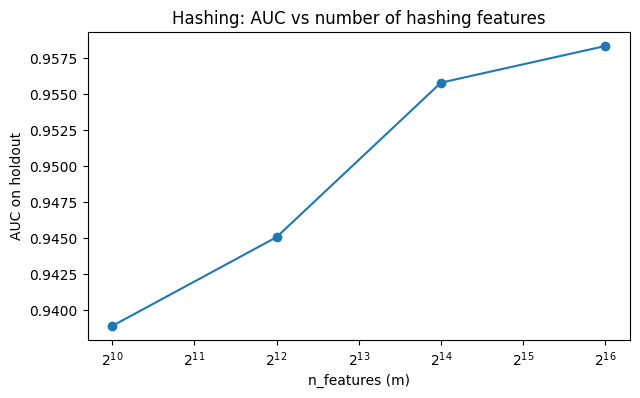

In [28]:
import matplotlib.pyplot as plt

ms = [m for m, auc in results]
aucs = [auc for m, auc in results]

plt.figure(figsize=(7,4))
plt.plot(ms, aucs, marker="o")
plt.xscale("log", base=2)
plt.xlabel("n_features (m)")
plt.ylabel("AUC on holdout")
plt.title("Hashing: AUC vs number of hashing features")
plt.show()


---

## 6. Target encoding: compressing categories using the label (and the leakage trap)

### Core idea
Replace each category by a statistic of the target conditional on that category.

For regression:
$$
\text{TE}(c) \approx \mathbb{E}[y\mid x=c].
$$

A smoothed estimator is:
$$
\text{TE}_\alpha(c) = \frac{\sum_{i:x_i=c} y_i + \alpha \mu}{n_c + \alpha},
$$
where $\mu$ is the global mean and $\alpha>0$ controls shrinkage.

### Leakage risk
If you compute $\text{TE}(c)$ using the same rows you are encoding (especially inside cross-validation), you can leak target information and overestimate performance.

Leakage-safe training requires **out-of-fold target encoding**:
- For each fold, compute TE on the remaining folds and apply to the held-out fold.

We demonstrate with `diamonds.csv` predicting price from `cut`, `color`, `clarity`.


In [29]:
diam_te = diam.copy()

X = diam_te.drop(columns=["price"])
y = diam_te["price"].values

cat_cols = ["cut", "color", "clarity"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_cat = X[cat_cols].copy()
X_num = X[num_cols].copy()

X_train_cat, X_test_cat, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_cat, X_num, y, test_size=0.25, random_state=42
)


In [30]:
def target_encode_fit(df_cat, y, alpha=20.0):
    # Compute smoothed target means per category for each column.
    mu = float(np.mean(y))
    maps = {}
    for col in df_cat.columns:
        stats = pd.DataFrame({col: df_cat[col].values, "y": y})
        agg = stats.groupby(col)["y"].agg(["count", "mean"])
        enc = (agg["mean"] * agg["count"] + mu * alpha) / (agg["count"] + alpha)
        maps[col] = enc.to_dict()
    return maps, mu

def target_encode_apply(df_cat, maps, mu):
    out = pd.DataFrame(index=df_cat.index)
    for col in df_cat.columns:
        out[col + "_te"] = df_cat[col].map(maps[col]).fillna(mu).astype(float)
    return out

maps, mu = target_encode_fit(X_train_cat, y_train, alpha=50.0)
Xtr_te = target_encode_apply(X_train_cat, maps, mu)
Xte_te = target_encode_apply(X_test_cat, maps, mu)

Xtr = pd.concat([Xtr_te.reset_index(drop=True), X_train_num.reset_index(drop=True)], axis=1)
Xte = pd.concat([Xte_te.reset_index(drop=True), X_test_num.reset_index(drop=True)], axis=1)

reg = Ridge(alpha=1.0)
reg.fit(Xtr, y_train)
pred = reg.predict(Xte)

(mean_absolute_error(y_test, pred), r2_score(y_test, pred), Xtr.shape[1])


(np.float64(810.4586264501206), 0.8937561031532656, 10)

The above is valid for a train/test split (statistics were computed only on the training partition).
However, it is not sufficient for cross-validation unless you compute encodings out-of-fold.

Next: out-of-fold target encoding.


In [31]:
def oof_target_encode(df_cat, y, n_splits=5, alpha=50.0, random_state=42):
    df_cat = df_cat.reset_index(drop=True)
    y = np.asarray(y)
    mu = float(np.mean(y))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof = pd.DataFrame(index=np.arange(len(df_cat)))
    for col in df_cat.columns:
        oof[col + "_te"] = np.nan

    for train_idx, val_idx in kf.split(df_cat):
        df_tr, df_val = df_cat.iloc[train_idx], df_cat.iloc[val_idx]
        y_tr = y[train_idx]

        maps_fold, mu_fold = target_encode_fit(df_tr, y_tr, alpha=alpha)
        enc_val = target_encode_apply(df_val, maps_fold, mu_fold)

        oof.loc[val_idx, [c + "_te" for c in df_cat.columns]] = enc_val.values

    oof = oof.astype(float)

    maps_full, mu_full = target_encode_fit(df_cat, y, alpha=alpha)
    return oof, maps_full, mu_full

df_cat = X_train_cat.copy().reset_index(drop=True)
df_num = X_train_num.copy().reset_index(drop=True)
y_tr = y_train

oof_te, maps_full, mu_full = oof_target_encode(df_cat, y_tr, n_splits=5, alpha=50.0)

X_enc = pd.concat([oof_te, df_num], axis=1)
X_enc.head()


,cut_te,color_te,clarity_te,id,carat,depth,table,x,y,z
0,3939.408333,3159.618961,5024.964616,50585,0.70,59.5,56.0,5.79,5.81,3.45
1,3476.704758,5067.516281,3956.250275,17781,1.32,62.0,57.0,6.99,7.04,4.35
2,4583.762947,3905.978866,3250.632737,40989,0.45,61.4,61.0,4.95,4.89,3.02
3,3862.915819,5069.440490,3998.310188,20871,1.63,62.0,54.0,7.60,7.67,4.73
4,4567.051100,5067.516281,3341.862819,41299,0.51,59.4,60.0,5.26,5.21,3.11


In [32]:
# A quick evaluation split on the out-of-fold encoded training matrix
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_enc, y_tr, test_size=0.25, random_state=42)

reg = Ridge(alpha=1.0)
reg.fit(X_tr2, y_tr2)
pred = reg.predict(X_val2)

(mean_absolute_error(y_val2, pred), r2_score(y_val2, pred))


(np.float64(806.9206605068382), 0.8881253853563349)

### Practical target encoding checklist

1. Compute TE using training data only.
2. In CV, compute encodings out-of-fold.
3. Use smoothing (shrinkage) to stabilize rare categories.
4. For time series or grouped data, folds must respect temporal or group boundaries.

Target encoding often shines when cardinality is high and one-hot is too large.


---

## 7. Mixed encoders in a single workflow

Real projects often combine encoders:
- one-hot for small nominal fields,
- hashing for large or evolving vocabularies,
- ordinal for truly ordered categories,
- target encoding for high-cardinality categories when strict leakage controls are feasible.

We demonstrate a mixed design on `Fast_Food_Restaurants_US.csv`:
- one-hot for `province`,
- hashing for `city`, `categories`, and `name`,
- a linear classifier on a toy label to demonstrate end-to-end mechanics.


In [33]:
path_ff = "../../../Datasets/Classification/Fast_Food_Restaurants_US.csv"
ff = pd.read_csv(path_ff)

ff2 = ff.copy()
ff2["label_chain"] = ff2["name"].astype(str).str.contains(r"(?i)wendy|taco|sonic|arb(?:y|ies)|burger|mcdonald|kfc", regex=True).astype(int)

ff2 = ff2[["province","city","categories","name","label_chain"]].fillna("")
ff2.head()


,province,city,categories,name,label_chain
0,LA,Thibodaux,American Restaurant and Fast Food Restaurant,SONIC Drive In,1
1,LA,Thibodaux,Fast Food Restaurants,SONIC Drive In,1
2,TN,Pigeon Forge,Fast Food Restaurant,Taco Bell,1
3,TN,Pigeon Forge,Fast Food,Arby's,1
4,GA,Morrow,Fast Food Restaurant,Steak 'n Shake,0


In [34]:
def ff_row_to_dict(row):
    d = {}
    d[f"city={row['city']}"] = 1
    d[f"name={row['name']}"] = 1
    cats = str(row["categories"]).replace(" and ", ",").split(",")
    for c in cats:
        c = c.strip()
        if c:
            d[f"cat={c}"] = 1
    return d

X = ff2[["province","city","categories","name"]].copy()
y = ff2["label_chain"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [35]:
pre_ohe_prov = ColumnTransformer(
    transformers=[("prov", OneHotEncoder(handle_unknown="ignore"), ["province"])],
    remainder="drop"
)

hasher = FeatureHasher(n_features=2**13, input_type="dict")

train_dicts = X_train.apply(ff_row_to_dict, axis=1).tolist()
test_dicts = X_test.apply(ff_row_to_dict, axis=1).tolist()

Xh_train = hasher.transform(train_dicts)
Xh_test = hasher.transform(test_dicts)

Xp_train = pre_ohe_prov.fit_transform(X_train)
Xp_test = pre_ohe_prov.transform(X_test)

from scipy.sparse import hstack
X_train_all = hstack([Xp_train, Xh_train]).tocsr()
X_test_all = hstack([Xp_test, Xh_test]).tocsr()

X_train_all.shape


(7500, 8242)

In [36]:
clf = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=2000, random_state=42)
clf.fit(X_train_all, y_train)

proba = clf.predict_proba(X_test_all)[:, 1]
pred = (proba >= 0.5).astype(int)

accuracy_score(y_test, pred), roc_auc_score(y_test, proba)


(0.9932, np.float64(0.9992005818262308))

This pattern is common in industry:
- collision-free encodings where feasible,
- hashing for high-cardinality or evolving categorical fields,
- compact representations when memory and latency matter.

Next, we provide a decision framework and a set of recommended exercises.


---

## 7.5 Common pitfalls and debugging checks

Even when you choose an appropriate encoder, issues often arise in practice. The following checks prevent many downstream surprises.

### Pitfall A: exploding cardinality
Before committing to one-hot, measure the number of unique categories:
$$
K_j = |\{x^{(i)}_j\}_{i=1}^n|.
$$
If $K_j$ is large (e.g., thousands) and the column is not obviously ordinal, consider hashing or target encoding.

### Pitfall B: rare categories
Very rare categories can behave like noise, especially for linear models.
A standard remedy is to replace categories with frequency below a threshold by `"Other"` *before* encoding.

### Pitfall C: unseen categories at inference time
If your production data contains new categories, your pipeline must define behavior:
- one-hot: ignore unseen categories,
- ordinal: map unseen to a reserved code (e.g., -1),
- hashing: naturally handles them,
- target: map unseen to the global mean (or prior).

We implement a minimal rare-category grouping utility on the fast-food dataset.


In [37]:
def group_rare_categories(s, min_count=50, other_label="Other"):
    counts = s.value_counts(dropna=False)
    rare = counts[counts < min_count].index
    return s.where(~s.isin(rare), other_label)

# Example: city cardinality and rare grouping
city_counts = ff2["city"].value_counts()
print("Unique cities:", ff2["city"].nunique())
print("Top 10 cities:")
print(city_counts.head(10))

ff2_grouped = ff2.copy()
ff2_grouped["city_grouped"] = group_rare_categories(ff2_grouped["city"], min_count=30)

print("\nUnique cities after grouping:", ff2_grouped["city_grouped"].nunique())
print("Top 10 grouped cities:")
print(ff2_grouped["city_grouped"].value_counts().head(10))


Unique cities: 2764
Top 10 cities:
city
Houston        107
Las Vegas       82
Phoenix         78
Columbus        72
Dallas          66
Orlando         65
Los Angeles     64
Miami           62
Chicago         57
San Antonio     54
Name: count, dtype: int64

Unique cities after grouping: 35
Top 10 grouped cities:
city_grouped
Other          8363
Houston         107
Las Vegas        82
Phoenix          78
Columbus         72
Dallas           66
Orlando          65
Los Angeles      64
Miami            62
Chicago          57
Name: count, dtype: int64


---

## 8. Decision framework: choosing an encoder

### 8.1. Match semantics first
- If the category is **ordered**, use ordinal encoding with an explicit order.
- If it is **nominal**, do not impose an order.

### 8.2. Control dimensionality
Let $K$ be cardinality of a nominal feature.

- One-hot: dimension grows as $K$ (exact and interpretable).
- Hashing: dimension fixed at $m$ (approximate, collisions).
- Target encoding: dimension fixed at 1 per feature (strong, but leakage-prone).

### 8.3. Consider the model family

| Model family | Common encodings | Why |
|---|---|---|
| Linear / GLM | one-hot, hashing, target | linear models like sparse high-dimensional features; TE can compress large vocabularies |
| Distance-based | one-hot (careful), ordinal (only if true order) | distances in encoded space matter |
| Trees / GBDT | ordinal, one-hot, or native categorical splits | trees can split on integer codes, but native categorical handling is often best when available |

### 8.4. Handle unseen categories
- One-hot: `handle_unknown="ignore"`.
- Ordinal: use `unknown_value` with `handle_unknown="use_encoded_value"`.
- Hashing: naturally handles new categories.
- Target: map unseen categories to the global mean $\mu$.

### 8.5. Leakage discipline for target encoding
If your encoding uses the label, compute it so that each row’s encoded value is computed without using that row’s target (out-of-fold).


---

## 9. Exercises (recommended)

1. **One-hot with regularization**: On `drug200.csv`, tune `C` for logistic regression and measure how accuracy changes.
2. **Ordinal vs one-hot**: On `diamonds.csv`, compare ordinal vs one-hot for `cut/color/clarity` using Ridge and SGDRegressor.
3. **Hashing dimension**: On `airports.csv`, vary `n_features` (e.g., $2^{10}$, $2^{12}$, $2^{14}$, $2^{16}$) and plot AUC.
4. **Leakage demo**: Implement leaky target encoding inside CV and show how performance is overestimated.
5. **Rare category grouping**: Replace categories with frequency < 10 by `"Other"` and compare one-hot dimensionality and performance.

Completing these exercises will give you operational mastery of categorical encodings used in classical ML pipelines.
